# AUTO ML

# What is H2O?


H2O is fast, scalable, open-source machine learning and deep learning for Smarter Applications. With H2O, enterprises like PayPal,
Nielsen Catalina, Cisco and others can use all of their data without sampling and get accurate predictions faster. Advanced algorithms, like
Deep Learning, Boosting, and Bagging Ensembles are readily available for application designers to build smarter applications through
elegant APIs. Some of our earliest customers have built powerful domain-specific predictive engines for Recommendations, Customer
Churn, Propensity to Buy, Dynamic Pricing and Fraud Detection for the Insurance, Healthcare, Telecommunications, AdTech, Retail and
Payment Systems.
Using in-memory compression techniques, H2O can handle billions of data rows in-memory, even with a fairly small cluster. The platform
includes interfaces for R, Python, Scala, Java, JSON and Coffeescript/JavaScript, along with a built-in web interface, Flow, that make it
easier for non-engineers to stitch together complete analytic workflows. The platform was built alongside (and on top of) both Hadoop and
Spark Clusters and is typically deployed within minutes.
H2O implements almost all common machine learning algorithms, such as generalized linear modeling (linear regression, logistic
regression, etc.), Naïve Bayes, principal components analysis, time series, k-means clustering, and others. H2O also implements best-inclass
algorithms such as Random Forest, Gradient Boosting, and Deep Learning at scale. Customers can build thousands of models and
compare them to get the best prediction results.
H2O is nurturing a grassroots movement of physicists, mathematicians, computer and data scientists to herald the new wave of discovery
with data science. Academic researchers and Industrial data scientists collaborate closely with our team to make this possible. Stanford
university giants Stephen Boyd, Trevor Hastie, Rob Tibshirani advise the H2O team to build scalable machine learning algorithms. With
100s of meetups over the past two years, H2O has become a word-of-mouth phenomenon growing amongst the data community by a 100-
fold and is now used by 12,000+ users, deployed in 2000+ corporations using R, Python, Hadoop and Spark.

# Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, model_selection
from sklearn.model_selection import train_test_split
from tpot import TPOTRegressor
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

C:\Users\dhari\Anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)
C:\Users\dhari\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# Changing current working directory

In [173]:
import os
cwd = os.getcwd()
print (cwd)
%cd "Instacart data"

C:\Users\dhari\BDIA_Spring19\BDIA_FINAL_PROJECT
C:\Users\dhari\BDIA_Spring19\BDIA_FINAL_PROJECT\Instacart data


# Read Inputs into data frame

In [3]:
order_products_train = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/order_products__train.csv")
order_products_prior = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/order_products__prior.csv")
orders = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/orders.csv")
products = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/products.csv")
aisles = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/aisles.csv")
departments = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/departments.csv")

Firstly, let's explore order_products_train and order_products_prior files. These files specify which products were purchased in each order. More specifically, order_products__prior contains previous order contents for all customers and order_products_train contains the last orders for some customers only.

In [4]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


Now, let's concatenate them in the same order_products dataframe. This will concatenate all orders from previous customers plus new customers

In [5]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)

print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


# Missing Data in all orders

In [6]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
reordered,0,0.0
add_to_cart_order,0,0.0
product_id,0,0.0
order_id,0,0.0


There is no missing data in order_products_all dataset

# Reorder Frequency

In [7]:
grouped = order_products_all.groupby("reordered")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped

C:\Users\dhari\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,reordered,Total_products,Ratios
0,0,13863746,0.409938
1,1,19955360,0.590062


59 % of ordered products are previously ordered by customers.

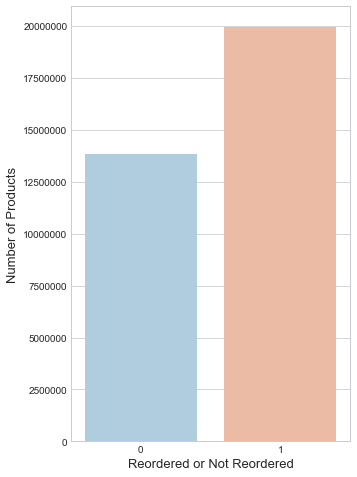

In [8]:
grouped  = grouped.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(grouped.index, grouped.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# To predict which previously purchased products will be in a user’s next order

Step 1 We will start with reading the orders file.

In [9]:

orders_df = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/orders.csv", usecols=["order_id","user_id","order_number"])

Since the objective is to predict which previously purchased products will be in next order, let us first get the list of all products purchased by the customer.

Step 2 Create data frame with old purchase

In [10]:
# read the prior order file #
prior_df = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/order_products__prior.csv")

# merge with the orders file to get the user_id #
prior_df = pd.merge(prior_df, orders_df, how="inner", on="order_id")
prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number
0,2,33120,1,1,202279,3
1,2,28985,2,1,202279,3
2,2,9327,3,0,202279,3
3,2,45918,4,1,202279,3
4,2,30035,5,0,202279,3


Step 3 Create data frame with latest purchase

In [11]:
# get the products and reorder status of the latest purchase of each user #
prior_grouped_df = prior_df.groupby("user_id")["order_number"].aggregate("max").reset_index()
prior_df_latest = pd.merge(prior_df, prior_grouped_df, how="inner", on=["user_id", "order_number"])
prior_df_latest = prior_df_latest[["user_id", "product_id", "reordered"]]
prior_df_latest.columns = ["user_id", "product_id", "reordered_latest"]
prior_df_latest.head()

,user_id,product_id,reordered_latest
0,59897,9755,1
1,59897,31487,0
2,59897,37510,1
3,59897,14576,1
4,59897,22105,0


Step 4. Get count of Number of reorders

In [12]:
# get the count of each product and number of reorders by the customer #
prior_df_agg = prior_df.groupby(["user_id","product_id"])["reordered"].aggregate(["count", "sum"]).reset_index()
prior_df_agg.columns = ["user_id", "product_id", "reordered_count", "reordered_sum"]
prior_df_agg.head()

,user_id,product_id,reordered_count,reordered_sum
0,1,196,10,9
1,1,10258,9,8
2,1,10326,1,0
3,1,12427,10,9
4,1,13032,3,2


Step 5 merge the prior df with latest df

In [13]:
prior_df_merge = pd.merge(prior_df_agg, prior_df_latest, how="left", on=["user_id","product_id"])
prior_df_merge=prior_df_merge.fillna(0)
prior_df_merge.head()

,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,196,10,9,1.0
1,1,10258,9,8,1.0
2,1,10326,1,0,0.0
3,1,12427,10,9,1.0
4,1,13032,3,2,1.0


Read the train and test dataset and then merge with orders data to get the user_id for the corresponding order_id.

In [14]:
orders_df.drop(["order_number"],axis=1,inplace=True)

train_df = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/order_products__train.csv", usecols=["order_id"])
train_df.head()

,order_id
0,1
1,1
2,1
3,1
4,1


Step 6 Get distinct order id in train_df. This will help in joining the data frame with orders

In [15]:
train_df = train_df.groupby("order_id").aggregate("count").reset_index()
train_df.head()

,order_id
0,1
1,36
2,38
3,96
4,98


join with Orders data frame

In [16]:
train_df = pd.merge(train_df, orders_df, how="inner", on="order_id")
train_df = train_df.fillna(0)
train_df.head()

,order_id,user_id
0,1,112108
1,36,79431
2,38,42756
3,96,17227
4,98,56463


In [17]:
test_df = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/sample_submission.csv", usecols=["order_id"])
test_df = pd.merge(test_df, orders_df, how="inner", on="order_id")
test_df.head()

,order_id,user_id
0,17,36855
1,34,35220
2,137,187107
3,182,115892
4,257,35581


Step 7 : Prepare test data frames

In [18]:
print(train_df.shape, test_df.shape)

(131209, 2) (75000, 2)


Step 8: Merge the train and test data with prior_df to get the products purchased previously by the customer.

In [19]:
train_df = pd.merge(train_df, prior_df_merge, how="inner", on="user_id")
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,112108,2067,1,0,0.0
1,1,112108,5707,2,1,1.0
2,1,112108,11109,2,1,0.0
3,1,112108,14947,3,2,1.0
4,1,112108,22035,2,1,0.0


In [20]:
test_df = pd.merge(test_df, prior_df_merge, how="inner", on="user_id")
#del prior_df, prior_grouped_df, prior_df_latest
test_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,17,36855,1283,1,0,0.0
1,17,36855,6291,1,0,0.0
2,17,36855,7035,1,0,0.0
3,17,36855,11494,1,0,0.0
4,17,36855,13107,3,2,1.0


In [21]:
products_df = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/products.csv", usecols=["product_id", "aisle_id", "department_id"])
products_df.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


Step 9 : Add more features to training data from Products data frame

In [22]:
train_df = pd.merge(train_df, products_df, how="inner", on="product_id")
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,2067,1,0,0.0,3,19
1,96,17227,2067,1,0,0.0,3,19
2,3243,206024,2067,1,0,0.0,3,19
3,12950,11456,2067,1,0,0.0,3,19
4,17683,177724,2067,1,0,0.0,3,19


In [23]:
test_df = pd.merge(test_df, products_df, how="inner", on="product_id")
test_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,17,36855,1283,1,0,0.0,100,21
1,657743,16994,1283,1,0,0.0,100,21
2,834223,92628,1283,1,0,0.0,100,21
3,1446886,75870,1283,1,0,0.0,100,21
4,1518981,118458,1283,3,2,0.0,100,21


Now we have all the products that has been purchased previously by the customer along with some characteristics / featrures. So we can use the train dataset to populate the target variable i.e., whether the product has been reordered in the next order.

In [24]:
train_y_df = pd.read_csv("../BDIA_FINAL_PROJECT/Instacart data/order_products__train.csv", usecols=["order_id", "product_id", "reordered"])
train_y_df = pd.merge(train_y_df, orders_df, how="inner", on="order_id")
train_y_df = train_y_df[["user_id", "product_id", "reordered"]]
train_df = pd.merge(train_df, train_y_df, how="left", on=["user_id", "product_id"])
train_df["reordered"].fillna(0, inplace=True)
print(train_df.shape)

(8474661, 9)


# H2O AutoML

Import the H2O library and initilaze it with the memory size of 40 GB

In [51]:
import h2o
from h2o.automl import H2OAutoML
h2o.init(max_mem_size = "40G")

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 hours 15 mins
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.4
H2O cluster version age:,2 months and 10 days
H2O cluster name:,H2O_from_python_dhari_5mou2j
H2O cluster total nodes:,1
H2O cluster free memory:,17.21 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


add the columns to the H2O data frame so that we can train the model using the training dataset and test dataset

In [166]:
#slice the train data ,so we can use H2o 

In [126]:
train_df_copy=train_df[:100000]

In [127]:
train_df_copy.shape

(100000, 9)

In [128]:
train_df_copy.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id,reordered
0,1,112108,2067,1,0,0.0,3,19,0.0
1,96,17227,2067,1,0,0.0,3,19,0.0
2,3243,206024,2067,1,0,0.0,3,19,0.0
3,12950,11456,2067,1,0,0.0,3,19,0.0
4,17683,177724,2067,1,0,0.0,3,19,0.0


In [165]:
#slice the test data 

In [129]:
test_df_copy = test_df[:100000]

In [130]:
test_df_copy.shape

(100000, 8)

In [131]:
test_df_copy.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,17,36855,1283,1,0,0.0,100,21
1,657743,16994,1283,1,0,0.0,100,21
2,834223,92628,1283,1,0,0.0,100,21
3,1446886,75870,1283,1,0,0.0,100,21
4,1518981,118458,1283,3,2,0.0,100,21


In [167]:
#now we can use H2OFrame To initialize train and test

In [132]:
htrain = h2o.H2OFrame(train_df_copy)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [133]:
htest = h2o.H2OFrame(test_df_copy)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [134]:
htrain.head()

order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id,reordered
1,112108,2067,1,0,0,3,19,0
96,17227,2067,1,0,0,3,19,0
3243,206024,2067,1,0,0,3,19,0
12950,11456,2067,1,0,0,3,19,0
17683,177724,2067,1,0,0,3,19,0
18711,116422,2067,6,5,0,3,19,0
19097,3298,2067,18,17,0,3,19,0
19794,33842,2067,26,25,0,3,19,1
20407,159092,2067,3,2,1,3,19,1
22151,85190,2067,1,0,0,3,19,0


In [135]:
htest.head()

order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
17,36855,1283,1,0,0,100,21
657743,16994,1283,1,0,0,100,21
834223,92628,1283,1,0,0,100,21
1.44689e+06,75870,1283,1,0,0,100,21
1.51898e+06,118458,1283,3,2,0,100,21
1.55972e+06,185709,1283,2,1,1,100,21
1.57567e+06,124428,1283,1,0,0,100,21
2.29072e+06,155269,1283,1,0,0,100,21
2.82939e+06,19117,1283,1,0,0,100,21
17,36855,6291,1,0,0,121,14


In [168]:
#Initialize X

In [143]:
X=htrain.columns

In [144]:
X

['order_id',
 'user_id',
 'product_id',
 'reordered_count',
 'reordered_sum',
 'reordered_latest',
 'aisle_id',
 'department_id',
 'reordered']

In [ ]:
#initialize y 

In [145]:
y='reordered'
y

'reordered'

In [169]:
#Drop Target column from X

In [146]:
X.remove(y)
X

['order_id',
 'user_id',
 'product_id',
 'reordered_count',
 'reordered_sum',
 'reordered_latest',
 'aisle_id',
 'department_id']

In [ ]:
#Initialize Run Time =450 ..where model takes 450 seconds and give us the best models

In [147]:
run_time_secs = 450

aml = H2OAutoML(max_runtime_secs = run_time_secs)

In [170]:
#H2O will Initilize and run for 450 sec

In [148]:
aml.train(x = X, y = y, training_frame = htrain)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [171]:
#Predicted Results

In [149]:
aml.leaderboard.as_data_frame()


,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_BestOfFamily_AutoML_20190426_1...,0.148719,0.385641,0.148719,0.297501,0.270398
1,StackedEnsemble_AllModels_AutoML_20190426_143354,0.148770,0.385708,0.148770,0.297599,0.270434
2,StackedEnsemble_BestOfFamily_AutoML_20190426_1...,0.148770,0.385708,0.148770,0.297599,0.270434
3,GBM_1_AutoML_20190426_144308,0.148780,0.385721,0.148780,0.297810,0.270519
4,GBM_1_AutoML_20190426_143354,0.148844,0.385803,0.148844,0.297627,0.270557
5,GLM_grid_1_AutoML_20190426_144308_model_1,0.151572,0.389322,0.151572,0.303506,0.272844
6,GLM_grid_1_AutoML_20190426_143354_model_1,0.151572,0.389322,0.151572,0.303506,0.272844
7,XRT_1_AutoML_20190426_144308,0.154665,0.393275,0.154665,0.299929,0.276737
8,XRT_1_AutoML_20190426_143354,0.154689,0.393305,0.154689,0.300398,0.276618
9,DRF_1_AutoML_20190426_144308,0.155247,0.394013,0.155247,0.301234,0.277341


In [150]:
lb = aml.leaderboard
print (lb)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20190426_144308,0.148719,0.385641,0.148719,0.297501,0.270398
StackedEnsemble_AllModels_AutoML_20190426_143354,0.14877,0.385708,0.14877,0.297599,0.270434
StackedEnsemble_BestOfFamily_AutoML_20190426_143354,0.14877,0.385708,0.14877,0.297599,0.270434
GBM_1_AutoML_20190426_144308,0.14878,0.385721,0.14878,0.29781,0.270519
GBM_1_AutoML_20190426_143354,0.148844,0.385803,0.148844,0.297627,0.270557
GLM_grid_1_AutoML_20190426_144308_model_1,0.151572,0.389322,0.151572,0.303506,0.272844
GLM_grid_1_AutoML_20190426_143354_model_1,0.151572,0.389322,0.151572,0.303506,0.272844
XRT_1_AutoML_20190426_144308,0.154665,0.393275,0.154665,0.299929,0.276737
XRT_1_AutoML_20190426_143354,0.154689,0.393305,0.154689,0.300398,0.276618
DRF_1_AutoML_20190426_144308,0.155247,0.394013,0.155247,0.301234,0.277341


In [151]:
test_y = aml.leader.predict(htest)
test_y = test_y.as_data_frame()

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [153]:
test_y.head()

,predict
0,0.030539
1,0.030500
2,0.022060
3,0.024508
4,0.060520


In [154]:
aml.leaderboard
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190426_144308
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.14586352775431627
RMSE: 0.3819208396439192
MAE: 0.2946411480886805
RMSLE: 0.26774446962518966
R^2: 0.21390720362911542
Mean Residual Deviance: 0.14586352775431627
Null degrees of freedom: 99999
Residual degrees of freedom: 99997
Null deviance: 18555.510040004126
Residual deviance: 14586.352775431626
AIC: 91287.32305835697

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.14871929061997402
RMSE: 0.3856414015895778
MAE: 0.2975014382825096
RMSLE: 0.27039757109030316
R^2: 0.1985168270805776
Mean Residual Deviance: 0.14871929061997402
Null degrees of freedom: 99999
Residual degrees of freedom: 99996
Null deviance: 18555.8890648631
Residual deviance: 14871.929061997402
AIC: 93228.23609256725


In [155]:
print(' H2O automl leader performace : ', aml.leader)

 H2O automl leader performace :  Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_AutoML_20190426_144308
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.14586352775431627
RMSE: 0.3819208396439192
MAE: 0.2946411480886805
RMSLE: 0.26774446962518966
R^2: 0.21390720362911542
Mean Residual Deviance: 0.14586352775431627
Null degrees of freedom: 99999
Residual degrees of freedom: 99997
Null deviance: 18555.510040004126
Residual deviance: 14586.352775431626
AIC: 91287.32305835697

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.14871929061997402
RMSE: 0.3856414015895778
MAE: 0.2975014382825096
RMSLE: 0.27039757109030316
R^2: 0.1985168270805776
Mean Residual Deviance: 0.14871929061997402
Null degrees of freedom: 99999
Residual degrees of freedom: 99996
Null deviance: 18555.8890648631
Residual deviance: 14871.929061997402
AIC: 93228.

shutting down the H2O cluster so we allocate the memory for the other usage.

In [157]:
h2o.cluster().shutdown()

H2O session _sid_b3fb closed.


# TPOT

Consider TPOT your Data Science Assistant. TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming.

In [158]:
from tpot import TPOTClassifier

then create an instance of TPOT

In [159]:
tpot = TPOTClassifier()

It's also possible to use TPOT for regression problems with the TPOTRegressor class. Other than the class name, a TPOTRegressor is used the same way as a TPOTClassifier. You can read more about the TPOTClassifier and TPOTRegressor classes in the API documentation.

In [160]:
tpot = TPOTClassifier(generations=2, population_size=20, cv=2,
                                    random_state=42, verbosity=2)

You can then proceed to evaluate the final pipeline on the testing set with the score function:

In [161]:
X = train_df_copy.drop('reordered',axis=1)
y = train_df_copy['reordered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

The fit function initializes the genetic programming algorithm to find the highest-scoring pipeline based on average k-fold cross-validation Then, the pipeline is trained on the entire set of provided samples, and the TPOT instance can be used as a fitted model.

In [162]:
tpot.fit(X_train,y_train)

C:\Users\dhari\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\dhari\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


A Jupyter Widget

Generation 1 - Current best internal CV score: 0.7576142140878483
Generation 2 - Current best internal CV score: 0.7576142140878483

Best pipeline: LogisticRegression(input_matrix, C=10.0, dual=False, penalty=l1)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=2,
        disable_update_check=False, early_stop=None, generations=2,
        max_eval_time_mins=5, max_time_mins=None, memory=None,
        mutation_rate=0.9, n_jobs=1, offspring_size=None,
        periodic_checkpoint_folder=None, population_size=20,
        random_state=42, scoring=None, subsample=1.0,
        template='RandomTree', use_dask=False, verbosity=2,
        warm_start=False)

Print the Error Rate

In [163]:
print('The RMSE of TPOT Regressor is {}'.format(tpot.score(X_test,y_test)))

The RMSE of TPOT Regressor is 0.8376666666666667


# Conclusion

I have sliced my data to run the H2O and Tpot but i didn't get satisfactory result.

I have got 10 different models for H2O but they are on sliced data and R2 is not that good.
I will Not use this for my prediction

# References

TPOT : https://epistasislab.github.io/tpot/
        
H2O : http://docs.h2o.ai/h2o/latest-stable/h2o-docs/faq/python.html
        
Github : https://github.com/nikbearbrown/CSYE_7245/tree/master/H2O
    

# Contribution 

I have tried Different Models and Auto ML and i have taken some of the code from kaggle notebooks and online material which is included in refrences . I can say about 45% i have tried by myself.!!



# Licence

Copyright 2019 DHARIT SHAH

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.